# Random Forest regressor

In [4]:
from sklearn.ensemble import RandomForestRegressor
from utils.utils_pixel import *
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
n_timesteps_in = 9
n_timesteps_out = 1
n_feats_in = 85
n_feats_out = 1
exp = 'clean_update'
sample_type = 'pixel_data'
feature_set = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "CP", "NDVI", "SCL",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SR" ,"SP", "T", "TCC", "TP", 
               "DEM", 
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15", "SAND60_100",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]
remove_band = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "CP", "SCL",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SP", "TCC",
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15", "SAND60_100",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]


n_epochs = 100
n_batches = 1000
n_batches_val = 100
n_batches_te = 100
batch_size = 40

In [32]:
def get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):

    r2_tot = 0
    mse_tot = 0
    
    for batch_nbr in range(n_batches_val):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='val', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 0 #NDVI only
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))
        

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        mse_tot += mean_squared_error(y_batch, y_pred)
        # Calculate R2 per sample
        r2_batch = 0 
        for sample in range(batch_size):
            y_true = np.concatenate([img[sample,:,0,:,:], label[sample,:,:,:]]).squeeze(1).squeeze(1)
            y_pred_all = np.concatenate([img[sample,:,0,:,:].squeeze(1).squeeze(1), [y_pred[sample]]])
            r2_batch += r2_score(y_true, y_pred_all)
        r2_tot += r2_batch/batch_size
    
    return r2_tot/n_batches_val, mse_tot/n_batches_val


def get_test_metrics(rf, batch_size, n_batches_te, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):
    
    r2_tot = 0
    mse_tot = 0
    
    for batch_nbr in range(n_batches_te):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='test', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 0 #NDVI only
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        mse_tot += mean_squared_error(y_batch, y_pred)
        r2_batch = 0 
        # Calculate R2 per sample
        for sample in range(batch_size):
            y_true = np.concatenate([img[sample,:,0,:,:], label[sample,:,:,:]]).squeeze(1).squeeze(1)
            y_pred_all = np.concatenate([img[sample,:,0,:,:].squeeze(1).squeeze(1), [y_pred[sample]]])
            r2_batch += r2_score(y_true, y_pred_all)
        r2_tot += r2_batch/batch_size
    
    return r2_tot/n_batches_te, mse_tot/n_batches_te

In [33]:
rf = RandomForestRegressor()

for epoch in tqdm(range(n_epochs)):
    for batch_nbr in range(n_batches):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here 
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='train', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)
        
        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 0
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

        # fit the regressor on the current batch
        rf.fit(X_batch, y_batch.ravel())
    
    r2, mse = get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
    print(f'Validation metrics for epoch {epoch}: R2 {r2}. MSE {mse}.') 


  1%|█▍                                                                                                                                             | 1/100 [05:52<9:41:33, 352.46s/it]

Validation metrics for epoch 0: R2 0.0269726441311086. MSE 0.03780667306764163.


  2%|██▊                                                                                                                                           | 2/100 [13:17<11:04:58, 407.12s/it]

Validation metrics for epoch 1: R2 -0.3047986680895439. MSE 0.03806399462916778.


  2%|██▊                                                                                                                                           | 2/100 [14:07<11:32:30, 423.99s/it]


KeyboardInterrupt: 

In [ ]:
# Save model for future use
with open('RF_clean_update.pkl', 'wb') as f:
    pickle.dump(rf, f)

#with open('RF_clean_update.pkl', 'wb') as f:
    #rf = pickle.load(f)

In [5]:
# Evaluate on test set

r2_test, mse_test = get_test_metrics(rf, batch_size, n_batches_te, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
print(f"Test MSE: {mse_test}, test R2: {r2_test}")

Test MSE: 0.04237465704019324, test R2: -0.5326445571831193


# Plot predictions

In [41]:
exp = 'nofilter'
batch = 20
batch_size = 40 

metadata_path = f'pixel_data/nofilter/test/'

# Get date/range of pred
all_loc_dates_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('all_loc_dates')])

all_loc_dates = []
for f in all_loc_dates_files:
    with open(metadata_path+f, 'rb') as f :
        all_loc_dates += pickle.load(f)
        
n_rep = 4000/len(all_loc_dates)
idx_start = int(np.floor((batch_size*batch)/n_rep))
idx_last = int(np.floor((batch_size*batch + batch_size)/n_rep))

In [49]:
# Plot some preds on the test set

img, label = load_batch(batch_size = batch_size, batch_nbr =batch, sample_type = 'pixel_data', split='val', exp='clean_update2', n_timesteps_out=1)

img = remove_features_batch_level(img, remove_band, feature_set)
label = remove_features_batch_level(label, remove_band, feature_set)

# still predict both, but dont use cp_idx for masking clouds in loss
cp_mask = label[:,:,0,:,:].squeeze(1).squeeze(1).squeeze(1).detach()
to_keep = 1 #NDVI only
label = label[:,:,to_keep,:,:]

X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

# Concatenate all timesteps after each other
X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

# calculate the MSE loss
y_pred = rf.predict(X_batch)

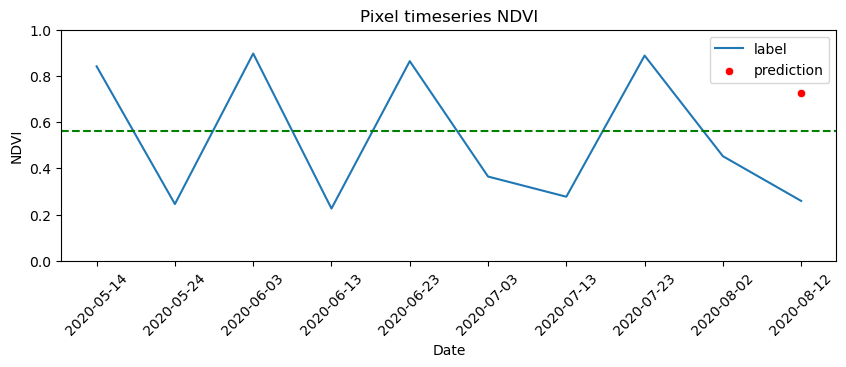

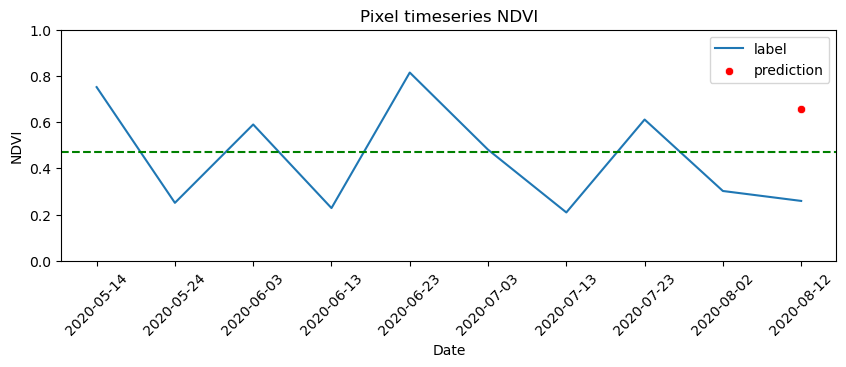

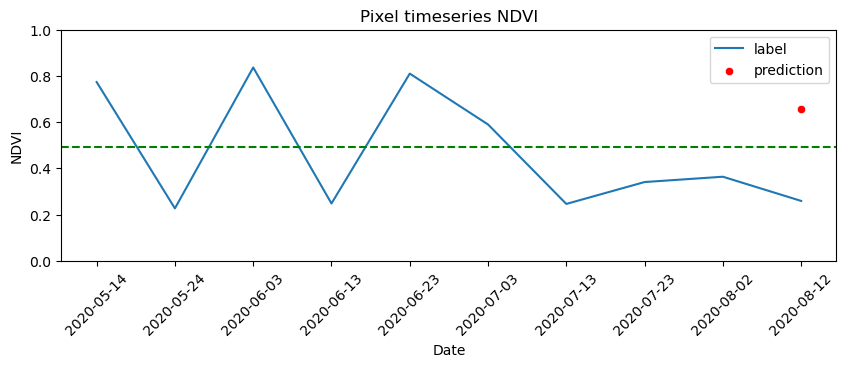

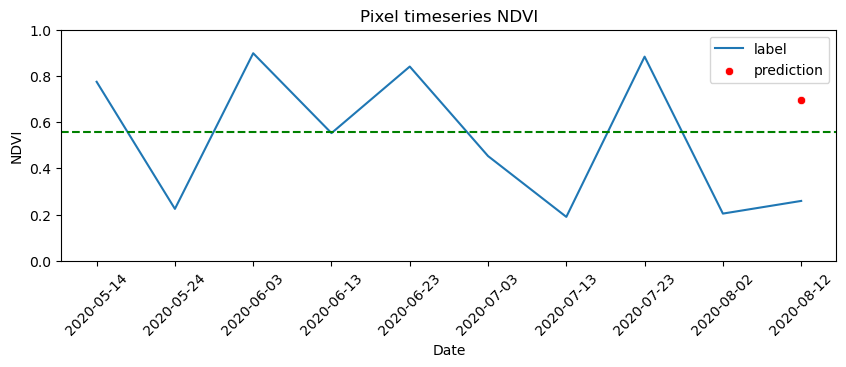

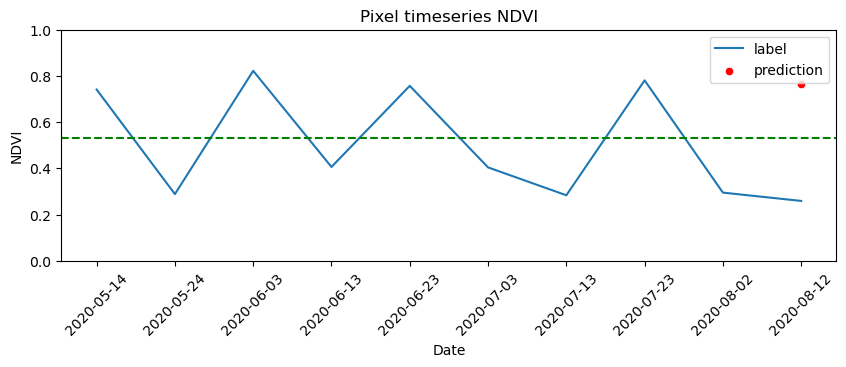

In [48]:
for sample_id in range(5):
    ndvi_input = img[sample_id, :, 1, :, :].squeeze(1).squeeze(1).numpy()
    ndvi_label = label[0, :, :, :].squeeze(1).squeeze(1).numpy()
    ndvi_cleaned = np.concatenate([ndvi_input, ndvi_label])
    dates = all_loc_dates[idx_start][1] + all_loc_dates[idx_start][3][:1]

    pix_pred = y_pred[sample_id]
    tensor_of_nans = th.full(ndvi_input.shape, float('nan')).numpy()
    pix_pred = np.concatenate([tensor_of_nans, [pix_pred]])

    fig, ax = plt.subplots(1,1,figsize=(10,3))
    plt.title('Pixel timeseries NDVI')
    sns.lineplot(ax=ax, y=ndvi_cleaned, x=dates,label='label')
    # add dot of predicted NDVI 
    sns.scatterplot(ax=ax, y=pix_pred, x=dates,label='prediction', color='red')
    plt.axhline(y=ndvi_input.mean(), color = 'g', linestyle = '--', label='data mean')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.ylim(0,1)
    plt.xticks(rotation=45)

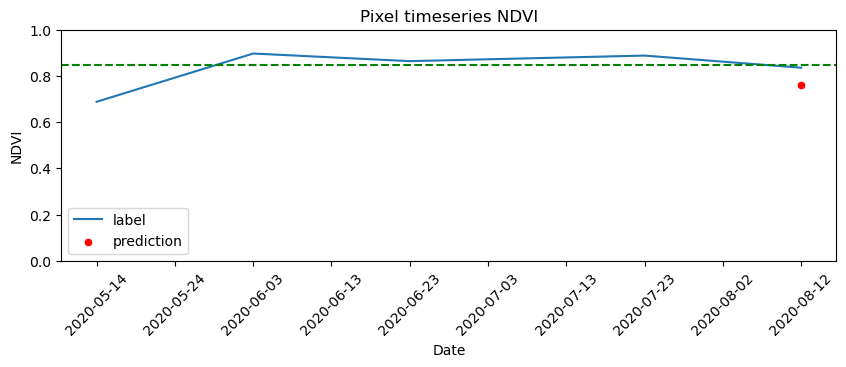

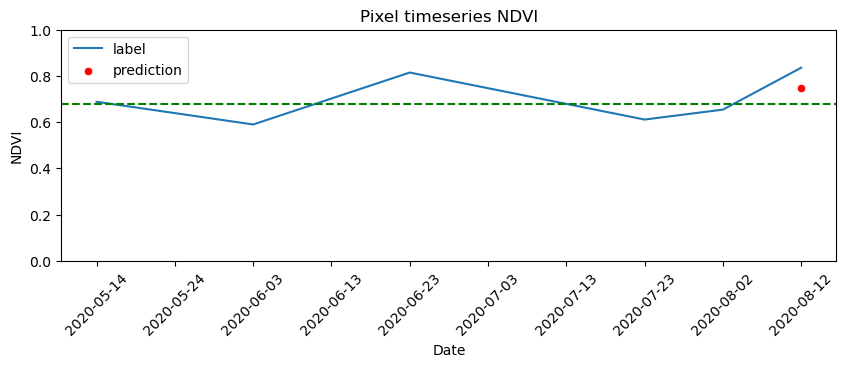

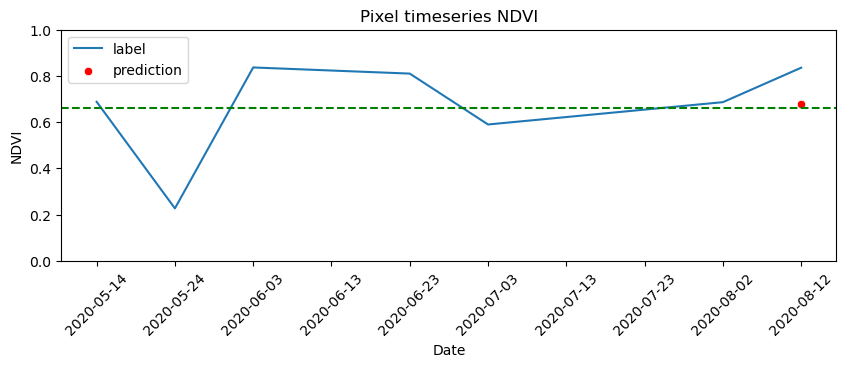

In [50]:
for sample_id in range(3):
    ndvi_input = img[sample_id, :, 1, :, :].squeeze(1).squeeze(1).numpy()
    ndvi_label = label[0, :, :, :].squeeze(1).squeeze(1).numpy()
    ndvi_cleaned = np.concatenate([ndvi_input, ndvi_label])
    dates = all_loc_dates[idx_start][1] + all_loc_dates[idx_start][3][:1]

    pix_pred = y_pred[sample_id]
    tensor_of_nans = th.full(ndvi_input.shape, float('nan')).numpy()
    pix_pred = np.concatenate([tensor_of_nans, [pix_pred]])

    fig, ax = plt.subplots(1,1,figsize=(10,3))
    plt.title('Pixel timeseries NDVI')
    sns.lineplot(ax=ax, y=ndvi_cleaned, x=dates,label='label')
    # add dot of predicted NDVI 
    sns.scatterplot(ax=ax, y=pix_pred, x=dates,label='prediction', color='red')
    plt.axhline(y=ndvi_input.mean(), color = 'g', linestyle = '--', label='data mean')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.ylim(0,1)
    plt.xticks(rotation=45)